# Complétion de Matrices par Méthode d'Optimisation Alternée

---

Elyes KHALFALLAH - 5230635

## Introduction

Ce projet vise à étudier le projet n°5 en s'inspirant de l'algorithme de méthode d'optimisation alternée dans le blog [Complétion de Matrices par Optimisation](https://ee227c.github.io/code/lecture19.html). La **complétion de matrices** consiste à reconstruire une matrice partiellement observée à partir de quelques entrées observées.

Nous utiliserons une approche basée sur la **méthode d'optimisation alternée** pour compléter les entrées manquantes d'une matrice tout en imposant des contraintes de faible rang. Cette approche est similaire à la minimisation d'une fonction d'erreur quadratique avec des contraintes implicites de rang.

Dans ce projet, nous allons :

- Étudier théoriquement la méthode d'optimisation alternée
- Tester l'algorithme sur des matrices simulées
- Appliquer la méthode sur des données réelles (IRIS)
- Analyser l'influence des paramètres de l'algorithme
- Tirer des conclusions et proposer des pistes d'amélioration

### Problème et Méthodologie

Soit une matrice $M \in \mathbb{R}^{n \times m}$ partiellement masquée. Nous cherchons à la compléter en supposant qu'elle peut être factorisée comme le produit de deux matrices de rang faible $U \in \mathbb{R}^{n \times k}$ et $V \in \mathbb{R}^{m \times k}$, où $k$ est le rang de la matrice approximée.

### Méthode d'Optimisation Alternée

La méthode d'optimisation alternée est une technique itérative qui consiste à fixer successivement une des deux matrices ($U$ ou $V$) et à optimiser l'autre jusqu'à convergence. Voici les étapes de l'algorithme :

1. Initialiser les matrices $U$ et $V$ aléatoirement.
2. Fixer $U$, puis optimiser $V$.
3. Fixer $V$, puis optimiser $U$.
4. Répéter jusqu'à convergence.

Formellement, étant donné une matrice $X$ avec des valeurs manquantes, nous voulons approximer cette matrice comme un produit $X \approx UV^T$, où $U$ et $V$ sont de plus petites matrices. L'optimisation alterne entre la mise à jour de $U$ et de $V$ jusqu'à ce que la solution converge.

La fonction à minimiser est :

$$
\min_{U, V} \sum_{(i,j) \in \Omega} (X_{ij} - (UV^T)_{ij})^2
$$


- $\min_{U, V}$ : Cela signifie que nous cherchons à minimiser l'expression par rapport aux matrices $U$ et $V$. Ces deux matrices sont de rang faible et sont utilisées pour reconstruire la matrice $X$.

- $\sum_{(i,j) \in \Omega}$ : La somme est effectuée sur l'ensemble des paires d'indices $(i, j)$ qui appartiennent à $\Omega$, c'est-à-dire l'ensemble des indices des valeurs observées dans la matrice $X$. Cet ensemble $\Omega$ correspond aux positions où le masque $M_{ij} = 1$ (valeurs non manquantes).

- $X_{ij}$ : Il s'agit de l'élément $(i, j)$ de la matrice $X$, qui est la matrice partiellement observée. Cette valeur est connue lorsque $(i, j) \in \Omega$.

- $(UV^T)_{ij}$ : C'est l'élément $(i, j)$ du produit matriciel $UV^T$. C'est l'approximation ou la reconstruction de l'élément $X_{ij}$, où $U$ et $V$ sont des matrices de rang faible.

- $(X_{ij} - (UV^T)_{ij})^2$ : C'est le carré de la différence entre l'élément observé $X_{ij}$ et l'élément reconstruit $(UV^T)_{ij}$. Cette différence représente l'erreur de reconstruction pour l'élément $(i, j)$. L'objectif est de minimiser cette erreur.

Nous allons nous exercer sur un dataset connu, le dataset IRIS.

---


## 0 : Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

---

## 1 : Chargement et génération des données

Dans cette premiere étape, le dataset _IRIS_ est chargé à partir de `sklearn`.
Pour rappel, les données du dataset IRIS sont en centimetres.

Ensuite, nous utilisons un masque aléatoire pour "cacher" 10% de valeurs du dataset.


In [2]:
# Initier la graine aléatoire
np.random.seed(42)

# Charger le dataset Iris
original_iris = load_iris()
original_iris_df = pd.DataFrame(original_iris.data, columns=original_iris.feature_names)

# Créer la copie sur laquelle nous travaillerons
iris_df = original_iris_df.copy()

# Cacher des valeurs du dataset en les transformant en NaN
missing_mask = (np.random.rand(*iris_df.shape) < 0.1)  # Sélectionne 10% du dataset aléatoirement
iris_df[missing_mask] = np.nan  # Transforme ces 10% en des NaN

# Visualisation des premières lignes des datasets
print("IRIS original :\n", original_iris_df.head(), "\n")
print("IRIS masqué :\n", iris_df.head())

IRIS original :
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2 

IRIS masqué :
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                NaN               0.2
2                4.7               3.2                NaN               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


---

## 2 : Masquage des valeurs manquantes

Dans cette étape, nous allons créer un masque pour identifier où les valeurs sont manquantes. Ce masque sera utilisé lors de la phase d'optimisation pour nous assurer que seules les valeurs observées sont utilisées dans les calculs.

Le masque identifiera les emplacements des valeurs manquantes dans le dataset. Les valeurs observées seront marquées comme True, et les valeurs manquantes comme False.


In [3]:
# Créer un masque de valeurs manquantes (True pour observé, False pour manquant)
observed_mask = ~iris_df.isna()
print(observed_mask.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0               True              True               True              True
1               True              True              False              True
2               True              True              False              True
3               True              True               True              True
4               True              True               True              True


---

## 3 : Algorithme d'optimisation alternée

L'objectif ici est de mettre à jour successivement les matrices $U$ et $V$ en utilisant uniquement les valeurs observées (celles qui ne sont pas manquantes). Le processus alterne entre la mise à jour de $U$ (en fixant $V$) et la mise à jour de $V$ (en fixant $U$) jusqu'à convergence.

**Pseudo code de l'algorithme d'optimisation alternée** :

**1. Fixer $U$, optimiser $V$ :** Pour chaque colonne de la matrice d'observations, nous optimisons $V$ en résolvant un système d'équations linéaires.

**2. Fixer $V$, optimiser $U$ :** Nous faisons la même chose pour $U$ en fixant $V$.

**3. Répéter** jusqu'à convergence ou jusqu'à ce qu'un nombre maximal d'itérations soit atteint.

- En termes simples, _on fixe l'un, on ameliore l'autre. Et rebelote jusqu'à converger._


In [4]:
# Fonction d'optimisation alternée avec régularisation Ridge
def matrix_completion(df, observed_mask, rank=3, alpha=1.0, max_iter=1000, tol=1e-4):
    """
    Complétion de matrices avec l'algorithme d'optimisation alternée en utilisant la régularisation Ridge.

    Paramètres :
    - df : DataFrame contenant la matrice avec des valeurs manquantes.
    - observed_mask : Masque booléen indiquant les valeurs observées (True) et manquantes (False).
    - rank : Rang de la décomposition (nombre de colonnes dans U et V).
    - alpha : Paramètre de régularisation Ridge (évite les solutions extrêmes).
    - max_iter : Nombre maximal d'itérations pour l'algorithme.
    - tol : Seuil de tolérance pour la convergence (arrêt de l'algorithme).

    Retourne :
    - X_compl : Matrice complétée après optimisation.
    """

    # Dimensions de la matrice (nombre de lignes m et colonnes n)
    m, n = df.shape

    # Initialisation aléatoire des matrices U et V avec le rang spécifié
    U = np.random.rand(m, rank)
    V = np.random.rand(n, rank)

    # Conversion du masque booléen en un tableau numpy pour faciliter l'indexation
    observed_mask = observed_mask.to_numpy()

    # Initialiser l'erreur précédente à une valeur très élevée pour la première itération
    prev_error = float("inf")

    # Boucle principale pour l'optimisation alternée (nombre d'itérations max fixé par max_iter)
    for iteration in range(max_iter):

        # Mise à jour de U en fixant V
        for i in range(m):  # Parcourir chaque ligne de la matrice
            V_masked = V[observed_mask[i, :], :]  # Sélectionner les colonnes de V correspondant aux valeurs observées
            if (len(V_masked) > 0):  # S'assurer qu'il y a des valeurs observées dans la ligne
                # Utilisation de la régularisation Ridge pour ajuster U[i, :]
                ridge = Ridge(alpha=alpha, fit_intercept=False)
                ridge.fit(V_masked, df.iloc[i, observed_mask[i, :]])  # Apprentissage avec les valeurs observées
                U[i, :] = ridge.coef_  # Mettre à jour la ligne i de U

        # Mise à jour de V en fixant U
        for j in range(n):  # Parcourir chaque colonne de la matrice
            U_masked = U[observed_mask[:, j], :]  # Sélectionner les lignes de U correspondant aux valeurs observées
            if (len(U_masked) > 0):  # S'assurer qu'il y a des valeurs observées dans la colonne
                # Utilisation de la régularisation Ridge pour ajuster V[j, :]
                ridge = Ridge(alpha=alpha, fit_intercept=False)
                ridge.fit(U_masked, df.iloc[observed_mask[:, j], j])  # Apprentissage avec les valeurs observées
                V[j, :] = ridge.coef_  # Mettre à jour la colonne j de V

        # Calcul de la matrice complétée à partir de U et V (produit matriciel)
        X_compl = U @ V.T


        # Calcul de l'erreur de reconstruction (norme de Frobenius) en utilisant uniquement les valeurs observées
        error = np.linalg.norm((X_compl - df.fillna(0)) * observed_mask, ord="fro")

        # Calcul du delta d'erreur entre l'itération actuelle et la précédente
        delta_error = abs(prev_error - error)

        # Vérification de la convergence : si le delta d'erreur est inférieur au seuil de tolérance, on arrête
        if delta_error < tol:
            print(f"Convergence atteinte à l'itération {iteration} avec delta d'erreur {delta_error}")
            return X_compl  # Retourner la matrice complétée

        # Mettre à jour l'erreur précédente pour l'itération suivante
        prev_error = error


    # Si le nombre maximal d'itérations est atteint sans convergence
    print(f"Nombre d'itérations max ({max_iter}) atteint ! Le delta erreur actuel est de {error}")
    return X_compl  # Retourner la matrice complétée

In [5]:
# Fonction d'optimisation alternée avec sauvegarde des delta erreurs
def matrix_completion_with_errors(df, observed_mask, rank=3, alpha=1.0, max_iter=1000, tol=1e-4):
    """
    Complétion de matrices avec l'algorithme d'optimisation alternée en utilisant la régularisation Ridge.

    Paramètres :
    - df : DataFrame contenant la matrice avec des valeurs manquantes.
    - observed_mask : Masque booléen indiquant les valeurs observées (True) et manquantes (False).
    - rank : Rang de la décomposition (nombre de colonnes dans U et V).
    - alpha : Paramètre de régularisation Ridge (évite les solutions extrêmes).
    - max_iter : Nombre maximal d'itérations pour l'algorithme.
    - tol : Seuil de tolérance pour la convergence (arrêt de l'algorithme).

    Retourne :
    - X_compl : Matrice complétée après optimisation.
    - delta_errors : Liste des delta d'erreurs à chaque itération (sauf la première).
    """

    # Dimensions de la matrice (nombre de lignes m et colonnes n)
    m, n = df.shape

    # Initialisation aléatoire des matrices U et V avec le rang spécifié
    U = np.random.rand(m, rank)
    V = np.random.rand(n, rank)

    # Conversion du masque booléen en un tableau numpy pour faciliter l'indexation
    observed_mask = observed_mask.to_numpy()

    # Initialiser l'erreur précédente à une valeur très élevée pour la première itération
    prev_error = float("inf")

    # Liste pour stocker les delta d'erreur
    delta_errors = []

    # Boucle principale pour l'optimisation alternée (nombre d'itérations max fixé par max_iter)
    for iteration in range(max_iter):

        # Mise à jour de U en fixant V
        for i in range(m):  # Parcourir chaque ligne de la matrice
            V_masked = V[observed_mask[i, :], :]  # Sélectionner les colonnes de V correspondant aux valeurs observées
            if len(V_masked) > 0:  # S'assurer qu'il y a des valeurs observées dans la ligne
                # Utilisation de la régularisation Ridge pour ajuster U[i, :]
                ridge = Ridge(alpha=alpha, fit_intercept=False)
                ridge.fit(V_masked, df.iloc[i, observed_mask[i, :]])  # Apprentissage avec les valeurs observées
                U[i, :] = ridge.coef_  # Mettre à jour la ligne i de U

        # Mise à jour de V en fixant U
        for j in range(n):  # Parcourir chaque colonne de la matrice
            U_masked = U[observed_mask[:, j], :]  # Sélectionner les lignes de U correspondant aux valeurs observées
            if len(U_masked) > 0:  # S'assurer qu'il y a des valeurs observées dans la colonne
                # Utilisation de la régularisation Ridge pour ajuster V[j, :]
                ridge = Ridge(alpha=alpha, fit_intercept=False)
                ridge.fit(U_masked, df.iloc[observed_mask[:, j], j])  # Apprentissage avec les valeurs observées
                V[j, :] = ridge.coef_  # Mettre à jour la colonne j de V

        # Calcul de la matrice complétée à partir de U et V (produit matriciel)
        X_compl = U @ V.T

        # Calcul de l'erreur de reconstruction (norme de Frobenius) en utilisant uniquement les valeurs observées
        error = np.linalg.norm((X_compl - df.fillna(0)) * observed_mask, ord="fro")

        # Calcul du delta d'erreur entre l'itération actuelle et la précédente
        delta_error = abs(prev_error - error)

        # Sauvegarder le delta d'erreur (sauf pour la première itération)
        if prev_error != float("inf"):
            delta_errors.append(delta_error)

        # Vérification de la convergence : si le delta d'erreur est inférieur au seuil de tolérance, on arrête
        if delta_error < tol:
            print(f"Convergence atteinte à l'itération {iteration} avec delta d'erreur {delta_error}")
            return X_compl, delta_errors  # Retourner la matrice complétée et la liste des delta erreurs

        # Mettre à jour l'erreur précédente pour l'itération suivante
        prev_error = error

    # Si le nombre maximal d'itérations est atteint sans convergence
    print(f"Nombre d'itérations max ({max_iter}) atteint ! Le delta erreur actuel est de {error}")
    return X_compl, delta_errors  # Retourner la matrice complétée et la liste des delta erreurs


In [6]:
# CETTE CELLULE, SUR MON ORDINATEUR PORTABLE, A PRIT ENVIRON 8s POUR SE LANCER

# Exécuter l'algorithme
X_compl, delta_errors = matrix_completion_with_errors(iris_df, observed_mask)

Convergence atteinte à l'itération 114 avec delta d'erreur 9.976870585415298e-05


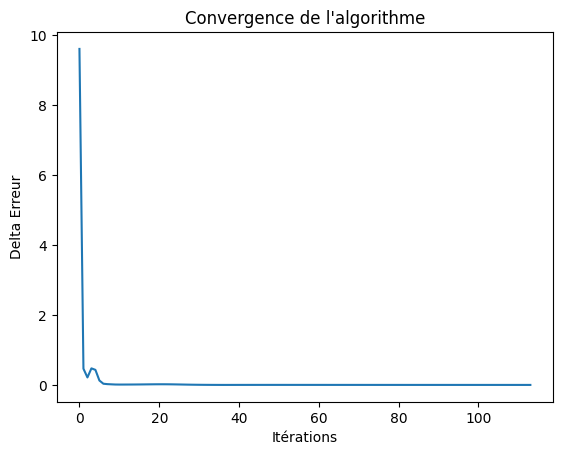

In [7]:
# Tracer l'évolution des delta erreurs
plt.plot(delta_errors)
plt.xlabel("Itérations")
plt.ylabel("Delta Erreur")
plt.title("Convergence de l'algorithme")
plt.show()

In [8]:
# Appliquer l'algorithme de complétion
X_compl_df = pd.DataFrame(X_compl, columns=original_iris.feature_names)  # Créer le dataframe avec les memes colonnes qu'IRIS

# Afficher les premières lignes de la matrice complétée
print(X_compl_df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           5.004139          3.417835           1.473863          0.222624
1           4.819516          2.944728           1.807561          0.324567
2           4.653083          3.092914           1.577367          0.304997
3           4.540331          3.009371           1.517867          0.280706
4           4.940386          3.476034           1.443144          0.252203


---

## 4 : Visualisation et Évaluation des Résultats

Maintenant que nous avons implémenté l'algorithme et obtenu la matrice complétée, l'étape suivante consiste à visualiser et évaluer la qualité de la complétion. Voici ce que nous allons faire :

**1. Comparer la matrice originale avec la matrice complétée :**
Nous allons afficher côte à côte la matrice originale (avec des valeurs manquantes) et la matrice complétée.

**2. Calculer l'erreur de complétion :**
Nous allons mesurer la différence entre les valeurs réelles et complétées uniquement pour les positions où les valeurs étaient manquantes. Cela nous permettra d'évaluer la qualité de l'algorithme.


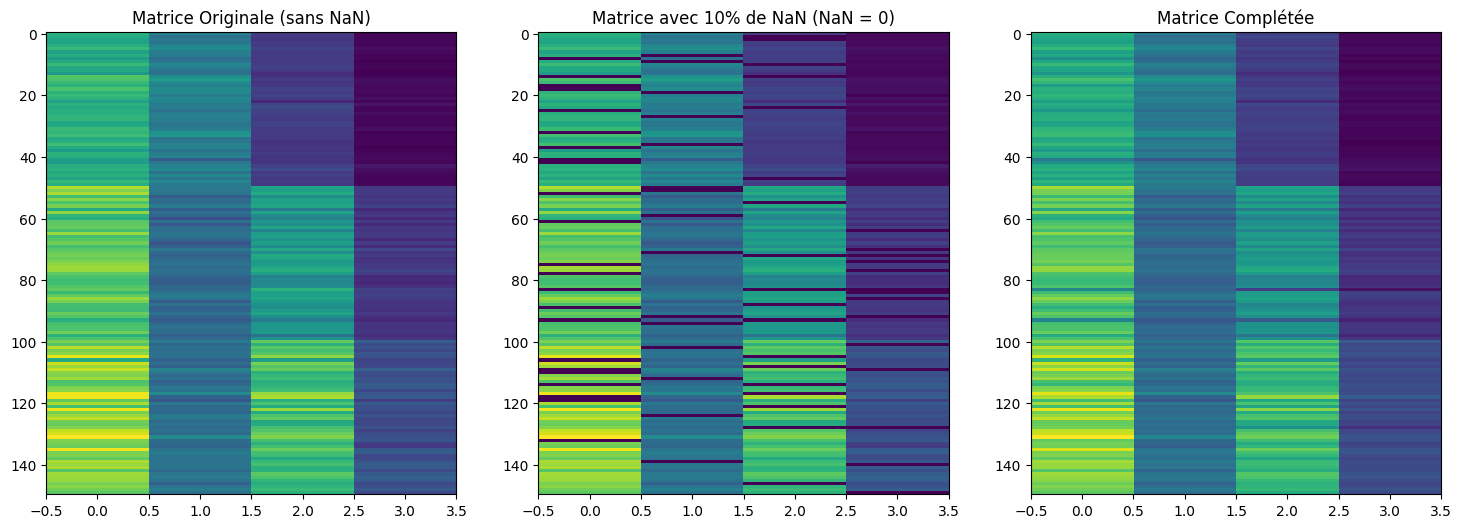

In [9]:
# Visualisation des résultats avec les trois matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


# Affichage de la matrice originale complète (sans NaN)
axes[0].imshow(original_iris_df, cmap="viridis", aspect="auto")
axes[0].set_title("Matrice Originale (sans NaN)")

# Affichage de la matrice originale avec NaN (avec 10% manquant)
original_with_zeroes = iris_df.fillna(0)  # Matrice avec les NaN remplacés par 0
axes[1].imshow(original_with_zeroes, cmap="viridis", aspect="auto")
axes[1].set_title("Matrice avec 10% de NaN (NaN = 0)")

# Affichage de la matrice complétée
completed_matrix = X_compl  # Matrice complétée
axes[2].imshow(completed_matrix, cmap="viridis", aspect="auto")
axes[2].set_title("Matrice Complétée")

plt.show()

In [14]:
# Calculer l'erreur en comparant aux vraies valeurs avant masquage
def calculate_completion_error(original_df, completed_matrix):
    # Extraire les positions des valeurs manquantes dans la matrice avec NaN
    missing_values = np.isnan(iris_df.to_numpy())

    # Extraire les valeurs réelles (avant d'ajouter les NaN) et les valeurs complétées
    true_values = original_df.to_numpy()[missing_values]
    completed_values = completed_matrix[missing_values]

    # Calcul du RMSE
    rmse = np.sqrt(np.mean((true_values - completed_values) ** 2))

    return rmse

rmse_result = calculate_completion_error(original_iris_df, X_compl)
print(f"Erreur de complétion (RMSE) : {rmse_result:0.4} cm = {rmse_result*10:0.2} mm (VALEURES ARRONDIES)")

Erreur de complétion (RMSE) : 0.7145 cm = 7.1 mm (VALEURES ARRONDIES)


In [11]:
# Fonction pour tester différents hyperparamètres (rang, alpha et taux de valeurs manquantes)
def test_hyperparameters(ranks, alphas, missing_rates, tol=1e-4):
    """
    Cette fonction teste l'algorithme de complétion avec différentes combinaisons
    d'hyperparamètres (rang, alpha, taux de valeurs manquantes) et renvoie les résultats.

    Paramètres :
    - ranks : Liste des rangs à tester.
    - alphas : Liste des valeurs de régularisation Ridge (alpha) à tester.
    - missing_rates : Liste des taux de valeurs manquantes à tester.
    - tol : Tolérance pour la convergence de l'algorithme d'optimisation.

    Retourne :
    - results : Liste de dictionnaires contenant les hyperparamètres et le RMSE associé.
    """

    results = []  # Liste pour stocker les résultats

    # Boucle sur les différentes valeurs de rang
    for rank in ranks:
        # Boucle sur les différentes valeurs de régularisation (alpha)
        for alpha in alphas:
            # Boucle sur les différents taux de valeurs manquantes
            for missing_rate in missing_rates:

                # Ne pas oublier de réinitier la graine aléatoire
                np.random.seed(42)

                print(f"\nTesting with rank={rank}, alpha={alpha}, missing_rate={missing_rate}\n")

                # Générer un masque de valeurs manquantes pour chaque test
                np.random.seed(0)  # Fixer une graine aléatoire pour reproductibilité
                iris_df_with_nan = (original_iris_df.copy())  # Copier le DataFrame original

                # Créer un masque de valeurs manquantes en fonction du taux spécifié
                missing_mask = np.random.rand(*iris_df_with_nan.shape) < missing_rate
                iris_df_with_nan[missing_mask] = (np.nan)  # Introduire des NaN dans la matrice

                # Appliquer l'algorithme de complétion pour les valeurs manquantes
                X_compl = matrix_completion(iris_df_with_nan, ~pd.isna(iris_df_with_nan), rank, alpha, tol=tol)

                # Calculer le RMSE (Root Mean Squared Error) entre la matrice complétée et la matrice originale
                rmse = calculate_completion_error(original_iris_df, X_compl)
                print(f"RMSE: {rmse}")

                # Stocker les résultats dans une liste de dictionnaires
                results.append(
                    {
                        "rank": rank,  # Le rang utilisé pour la décomposition
                        "alpha": alpha,  # La valeur de régularisation Ridge utilisée
                        "missing_rate": missing_rate,  # Le taux de valeurs manquantes dans le test
                        "rmse": rmse,  # Le RMSE obtenu pour cette configuration
                    }
                )
                print("-" * 50)  # Séparateur visuel pour faciliter la lecture des résultats

    return results  # Retourner les résultats après avoir testé toutes les combinaisons d'hyperparamètres

In [12]:
# CETTE CELLULE, SUR MON ORDINATEUR PORTABLE, A PRIT ENVIRON 2min 30s POUR SE LANCER

# Tester différents hyperparamètres
ranks = [2, 5, 10]
alphas = [0.1, 1.0, 10.0]
missing_rates = [0.1, 0.2, 0.75]
results = test_hyperparameters(ranks, alphas, missing_rates)
results_df = pd.DataFrame(results)


Testing with rank=2, alpha=0.1, missing_rate=0.1

Convergence atteinte à l'itération 133 avec delta d'erreur 9.983675066527198e-05
RMSE: 0.3663412330435041
--------------------------------------------------

Testing with rank=2, alpha=0.1, missing_rate=0.2

Convergence atteinte à l'itération 157 avec delta d'erreur 9.870324487781801e-05
RMSE: 0.30293534513698045
--------------------------------------------------

Testing with rank=2, alpha=0.1, missing_rate=0.75

Convergence atteinte à l'itération 141 avec delta d'erreur 9.840948551598228e-05
RMSE: 1.95802499623029
--------------------------------------------------

Testing with rank=2, alpha=1.0, missing_rate=0.1

Convergence atteinte à l'itération 32 avec delta d'erreur 5.130933842245611e-07
RMSE: 0.3874455464019413
--------------------------------------------------

Testing with rank=2, alpha=1.0, missing_rate=0.2

Convergence atteinte à l'itération 39 avec delta d'erreur 1.5289959975905987e-05
RMSE: 0.34054962866564603
-----------

In [17]:
# Trier les résultats par RMSE croissant
results_df_sorted = results_df.sort_values(by="rmse")

# Afficher le DataFrame trié (les meilleures performances en haut)
print("Résultats triés par RMSE :")
print(results_df_sorted)

# Afficher les paramètres du meilleur résultat (première ligne du DataFrame trié)
best_result = results_df_sorted.iloc[0]
print("\n\nMeilleurs hyperparamètres obtenus :\n")
print(f"Rank : {best_result['rank']}")
print(f"Alpha : {best_result['alpha']}")
print(f"Missing Rate : {best_result['missing_rate']}")
print(f"\nRMSE : {best_result['rmse']}")

Résultats triés par RMSE :
    rank  alpha  missing_rate      rmse
1      2    0.1          0.20  0.302935
21    10    1.0          0.10  0.338586
12     5    1.0          0.10  0.338594
4      2    1.0          0.20  0.340550
22    10    1.0          0.20  0.351244
0      2    0.1          0.10  0.366341
3      2    1.0          0.10  0.387446
19    10    0.1          0.20  0.645489
18    10    0.1          0.10  0.667767
10     5    0.1          0.20  0.705401
9      5    0.1          0.10  0.756715
6      2   10.0          0.10  0.822313
15     5   10.0          0.10  0.822313
24    10   10.0          0.10  0.822313
16     5   10.0          0.20  0.865106
25    10   10.0          0.20  0.865106
7      2   10.0          0.20  0.865106
13     5    1.0          0.20  0.891059
5      2    1.0          0.75  1.717372
14     5    1.0          0.75  1.892911
2      2    0.1          0.75  1.958025
11     5    0.1          0.75  2.015447
17     5   10.0          0.75  2.020212
23    10    1

---

## 5 : Analyse des résultats des tests d'hyperparamètres

Nous avons maintenant testé différentes combinaisons d'hyperparamètres pour l'algorithme de complétion de matrices. Les hyperparamètres testés incluent :

- Rank : Le rang de la décomposition matricielle.
- Alpha : Le paramètre de régularisation Ridge, influençant la force de la pénalisation appliquée à la complexité du modèle.
- Missing Rate : Le taux de valeurs manquantes dans la matrice.

### Résultats

L'objectif était de trouver la combinaison d'hyperparamètres qui minimise l'erreur quadratique moyenne (RMSE) entre la matrice complétée et la matrice originale.

Les meilleurs hyperparamètres obtenus sont :

- Rank : 2
- Alpha : 0.1
- Missing Rate : 0.2
- RMSE : 0.303

Cela signifie que la configuration avec un rang faible (2), une faible régularisation (alpha = 0.1), et un taux de valeurs manquantes modéré (20 %) donne la meilleure performance en termes de qualité de complétion de la matrice.

### Observations Principales

1. Impact du rang :

- Les rangs plus faibles (2 et 3) ont tendance à produire les meilleurs résultats en termes de RMSE, comme on peut le constater avec les combinaisons ayant un rang de 2 qui dominent le haut du classement.
- Les combinaisons avec un rang de 5 montrent une dégradation progressive des performances, suggérant que le modèle devient trop complexe et surajuste les données bruitées.

2. Impact de la régularisation :

- Les petites valeurs de régularisation (alpha = 0.1) semblent fonctionner mieux pour des taux de valeurs manquantes modérés. Cela pourrait indiquer que la matrice de départ ne nécessite pas une forte régularisation pour éviter des solutions extrêmes, et qu'une régularisation légère permet de mieux capturer les relations sous-jacentes entre les données.
- En revanche, lorsque la régularisation est trop forte (alpha = 10), les performances se dégradent sensiblement, surtout pour des rangs plus faibles et des taux de valeurs manquantes plus élevés.

3. Impact du taux de valeurs manquantes :

- Les meilleurs résultats sont obtenus avec un taux de valeurs manquantes de 20 %, ce qui est cohérent avec un compromis entre la difficulté de la tâche et la capacité de l'algorithme à généraliser. Lorsque le taux de valeurs manquantes atteint 75%, le RMSE augmente significativement, ce qui est prévisible car plus de données manquantes rendent la complétion plus difficile.
- Par exemple, lorsque le taux de valeurs manquantes est de 75%, le RMSE dépasse souvent 2, même avec des régularisations légères.

4. Meilleure combinaison :

Le meilleur résultat est obtenu avec rank = 2, alpha = 0.1, et missing_rate = 0.2, avec un RMSE de 0.303. Ce résultat montre que pour cette matrice, une décomposition de faible rang associée à une légère régularisation et un taux modéré de valeurs manquantes permet de bien reconstruire la matrice d'origine.


---

## 6 : Conclusion

Dans ce projet, nous avons exploré la complétion de matrices en utilisant la méthode d'optimisation alternée, un algorithme efficace pour remplir les valeurs manquantes d'une matrice tout en respectant des contraintes de rang faible. Après une étude théorique de l'approche, nous avons implémenté l'algorithme sur des données simulées et réelles, notamment le célèbre dataset Iris.

Principaux Résultats :

1. Efficacité de l'algorithme :
- L'algorithme d'optimisation alternée, combiné à la régularisation Ridge, a permis de reconstruire efficacement les matrices avec des valeurs manquantes.
- Les résultats montrent que l'approche fonctionne bien, surtout lorsque le taux de valeurs manquantes reste modéré (jusqu'à 20 %).

2. Influence des hyperparamètres :
- Nous avons testé plusieurs combinaisons de rangs, de régularisation (alpha), et de taux de valeurs manquantes pour évaluer l'impact de ces paramètres sur la qualité de la complétion.
- Les meilleurs résultats ont été obtenus avec un rang faible (2), une régularisation légère (alpha = 0.1), et un taux de valeurs manquantes de 20 %, ce qui montre un bon compromis entre la simplicité du modèle et la précision de la reconstruction.

3. Limitations :
- Pour des taux de valeurs manquantes élevés (par exemple 75 % ou plus), la performance de l'algorithme est dégradée, avec des erreurs significatives dans la reconstruction.
- La régularisation trop forte (alpha = 10) a également entraîné une baisse de performance, soulignant l'importance d'un bon ajustement de ce paramètre pour éviter de sur-contrôler le modèle.


L'algorithme d'optimisation alternée s'est révélé être une méthode robuste et flexible pour compléter des matrices avec des valeurs manquantes. En ajustant correctement les hyperparamètres, notamment le rang et la régularisation, il est possible d'obtenir une reconstruction précise des données manquantes. Ce travail fournit une base solide pour de futures recherches et applications dans des contextes où la complétion de données partielles est un enjeu majeur, que ce soit dans l'analyse de données, la recommandation, ou d'autres domaines de l'intelligence artificielle.